In [1]:
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import utils
pd.set_option('display.max_rows', 10)
%config InlineBackend.figure_format='retina'

In [ ]:
# load runs
df = utils.load_sweeps(['lm11m_adam_1d_sensitivity_seeds_1'])

In [3]:
# get min loss for each batch size
min_idx = df.groupby('opt.batch_size')['eval_loss'].idxmin()
min_loss = df.loc[min_idx]
min_loss[['opt.batch_size', 'opt.peak_lr', 'opt.b1', 'opt.t1', 'opt.t2', 'eval_loss']]

,opt.batch_size,opt.peak_lr,opt.b1,opt.t1,opt.t2,eval_loss
876,1,0.00170,0.995574,80000,10000000,3.679942
1167,4,0.00200,0.867659,10000,10000000,3.709871
1504,16,0.00400,0.909702,60000,10000000,3.716938
1497,64,0.00600,0.892646,200000,10000000,3.716591
1539,256,0.00707,0.913153,1000000,10000000,3.735875
307,1024,0.00500,0.885913,3000000,10000000,3.926278
198,4096,0.00250,0.784842,6000000,20000000,5.023688


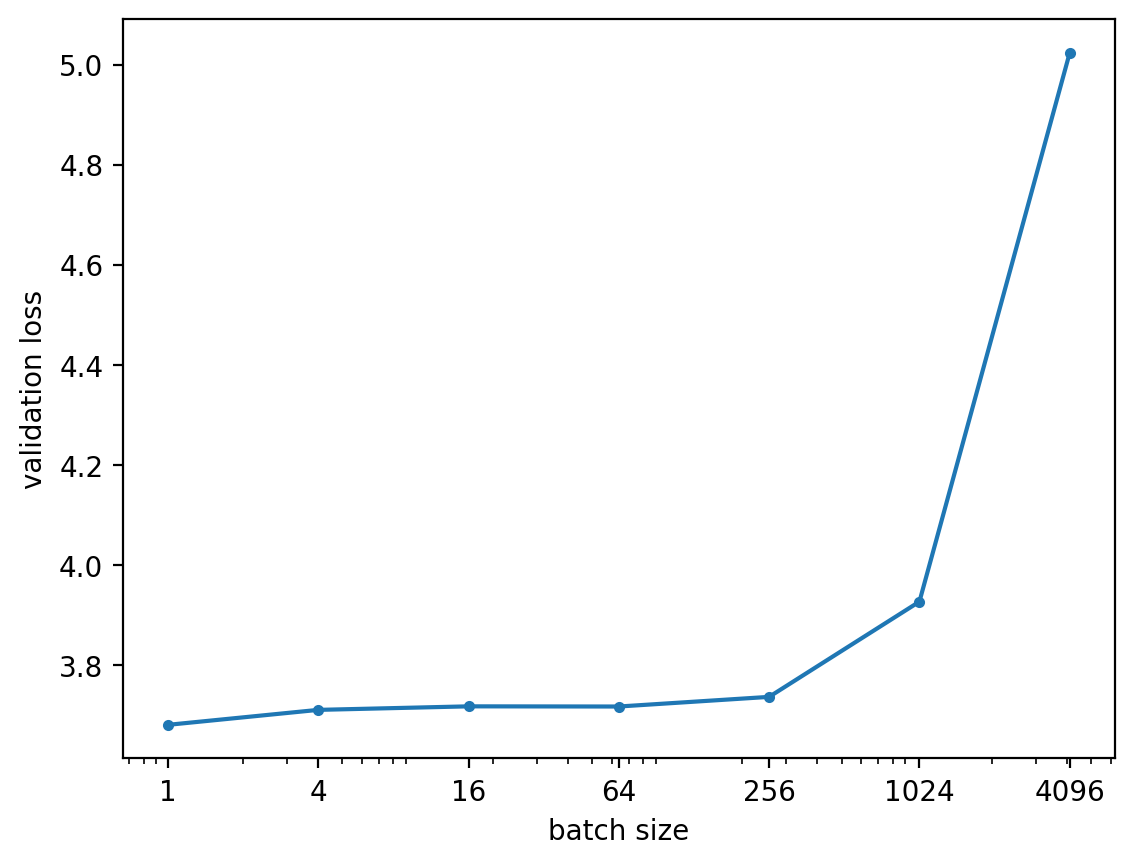

In [4]:
# plot min loss vs BS
x = min_loss['opt.batch_size']
y = min_loss['eval_loss']
fig, ax = plt.subplots()
ax.plot(x, y, '.-')
ax.set_xscale('log')
ax.set_xticks(x, x)
ax.set_xlabel('batch size')
ax.set_ylabel('validation loss')
# plt.savefig('plots/lm11m_adam_bs_min_loss.jpg', dpi=200)
plt.show()

In [5]:
# mode of each param for each BS
batch_sizes = np.sort(df['opt.batch_size'].unique())
hparams = ['opt.peak_lr', 'opt.b1', 'opt.t2']
rows = {}
for bs in batch_sizes:
    rows[bs] = {}
    for hparam in hparams:
        rows[bs][hparam] = df[df['opt.batch_size'] == bs][hparam].mode().item()
modes = pd.DataFrame(rows).T
modes

,opt.peak_lr,opt.b1,opt.t2
1,0.0017,0.991167,10000000.0
4,0.0020,0.965133,10000000.0
16,0.0020,0.909702,10000000.0
64,0.0030,0.892646,10000000.0
256,0.0050,0.913153,10000000.0
1024,0.0050,0.885913,10000000.0
4096,0.0025,0.784842,10000000.0


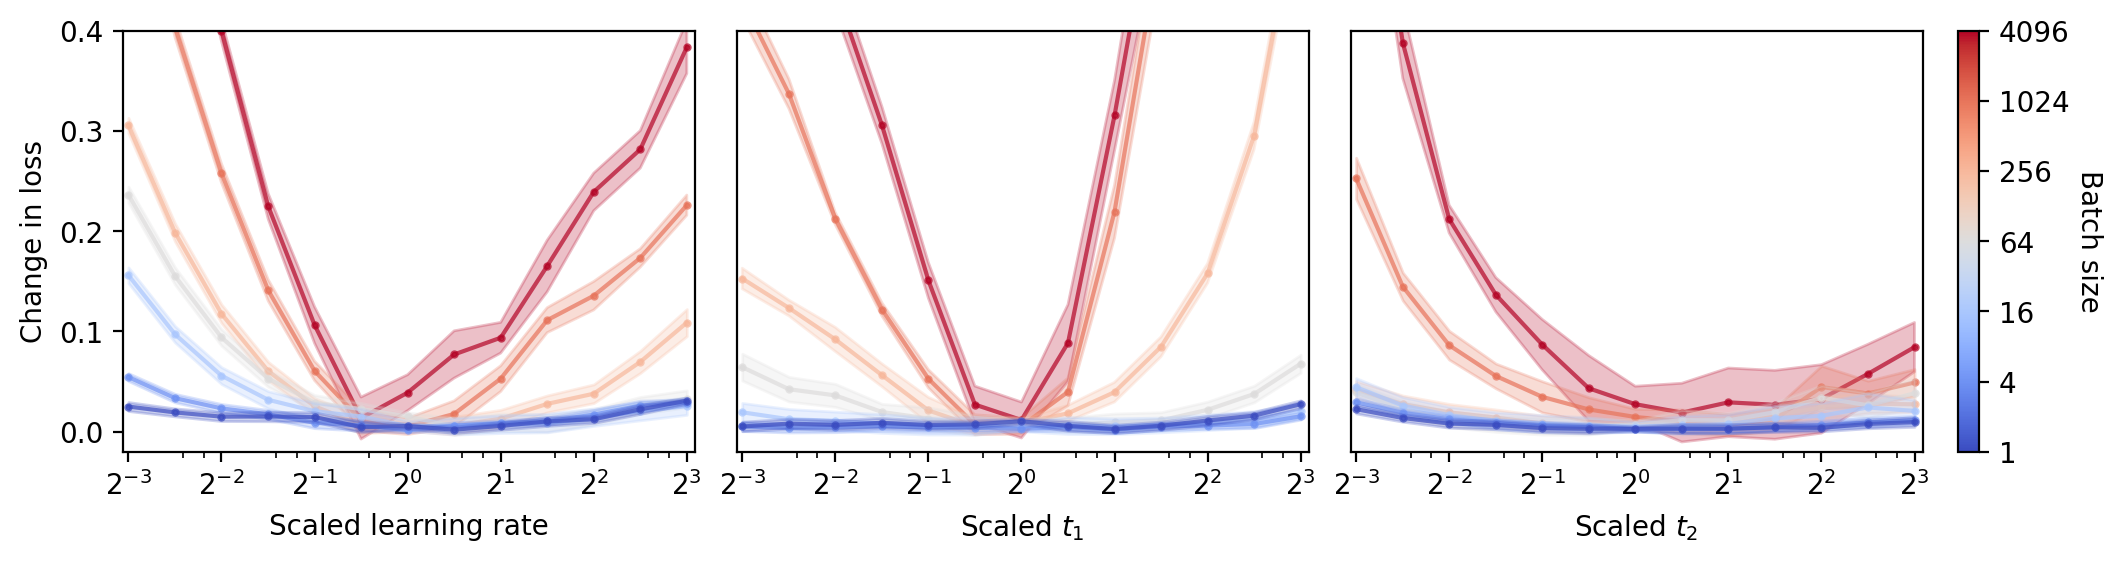

In [6]:
# plot 1d sensitivity, overlaid
batch_sizes = np.sort(df['opt.batch_size'].unique())
hparams = ['opt.peak_lr', 'opt.t1', 'opt.t2'] 
# hparams = ['opt.muon_lr', 'opt.muon_t1',]
fig, axs = plt.subplots(1, len(hparams), figsize=[3.5*len(hparams), 2.7], layout='constrained')

# generate plot colors
color_mapper = mpl.cm.ScalarMappable(cmap='coolwarm')
colors = color_mapper.to_rgba(np.log(batch_sizes))

# plot loss for each hparam
for i, hparam in enumerate(hparams):

    for j, bs in enumerate(batch_sizes):
        bs_runs = df.loc[df['opt.batch_size'] == bs]    

        # grid minimum
        # s = bs_runs.groupby(hparam)['eval_loss'].min()
        # x = s.index.values
        # y = s.values
        
        # 1d ablation
        keep = bs_runs
        for h2 in hparams:
            if h2 != hparam:
                keep = keep[keep[h2] == bs_runs[h2].mode().item()]
        x = keep[hparam].values
        y = keep['eval_loss'].values
        # o = np.argsort(x)
        # x, y = x[o], y[o]

        x_unique = np.sort(np.unique(x))
        y = [y[x==u] for u in x_unique] # [-1, n_seeds]
        # y_min, y_max = np.array([np.quantile(values, [0, 1]) for values in y]).T
        # y_min, y_max = np.array([np.quantile(values, [0.25, 0.75]) for values in y]).T
        se = np.array([np.std(v)/np.sqrt(len(v)) for v in y])
        y_mean = np.array([np.mean(values) for values in y])
        y_min, y_max = y_mean-se, y_mean+se
        x = x_unique

        x = x / x[len(x)//2]
        # x = x / x[np.argmin(y)]
        # x = x / x[(len(x) + np.argmin(y))//3]
        offset = 0.65*y_min.min() + 0.35*y_mean.min()
        y_mean -= offset
        y_min -= offset
        y_max -= offset
        
        # plot best loss for each hparam value
        color = f'C{j}'
        axs[i].plot(x, y_mean, '.-', c=colors[j], label=bs, zorder=-bs, alpha=0.7, ms=4) # lw=1.8, mec='white', mew=0.5, ms=8
        axs[i].fill_between(x, y_min, y_max, color=colors[j], alpha=0.25, zorder=-bs)
        axs[i].set_xscale('log', base=2)
        
        # axs[i].set_ylim([-0.012, 0.2])
        axs[i].set_ylim([-0.02, 0.4])
        axs[i].set_xlim([0.12, 8.5])
        axs[i].set_xticks(*zip(*[(2.0**i, f'$2^{{{i}}}$') for i in range(-3, 4)]))
        axs[i].set_xticks([2**i * sub for i in range(-3, 3) for sub in [1.5, 1.75]], minor=True)
        axs[i].set_xlabel(hparam)

# colorbar
cbar = fig.colorbar(color_mapper, ax=axs[-1], location='right', format=lambda x, _: f'{np.exp(x):g}')
cbar.set_ticks(np.log(batch_sizes))
cbar.ax.set_ylabel('Batch size', rotation=-90, labelpad=12)
# axs[1].legend(loc='upper right')

# labels
axs[0].set_xlabel('Scaled learning rate')
axs[1].set_xlabel('Scaled $t_1$')
axs[2].set_xlabel('Scaled $t_2$')
axs[0].set_ylabel('Change in loss')
for ax in axs[1:]: ax.set_yticks([])

# legend with maual order
# axs[2].legend(loc='upper right')
# handles, labels = axs[2].get_legend_handles_labels()
# order = list(reversed(range(len(handles))))
# axs[2].legend([handles[i] for i in order],[labels[i] for i in order], loc='upper right')

# plt.savefig('plots/lm11m_adam_sensitivity_1d.pdf')
plt.show()